In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from config import get_cfg
from op import Operation

cfg = get_cfg()

operation = Operation(cfg)

2020-04-22 13:10:58,485 - /home/zhengtao/Segmentation/BrainSeg/op.py[line:79] - INFO: config:
exp_dir: ./exp
epochs: 256
lr: 0.001
weight_decay: 0.0005
momentum: 0.9
epsilon: 1e-08
is_class_weight: False
model_type: No
drop_rate: 0.2
sample_T: 30
is_test: True
data_name: brains18
n_classes: 9
batch_size: 16
num_workers: 8
folders: ['1', '5', '7', '4', '148', '070', '14']
is_tumor: False
val_folds: ['1']
train_folds: ['5', '7', '4', '148', '070', '14']
memory_gpu: [0, 237, 11178, 11178, 11178, 11178, 11178, 11178]
device: cuda:2
cur_dir: ./exp/test-brains18=0422-131054
model_path: ./exp/test-brains18=0422-131054/model.pt
model_best_path: ./exp/test-brains18=0422-131054/model_best.pt
model_all_path: ./exp/test-brains18=0422-131054/model.pth
log_path: ./exp/test-brains18=0422-131054/exp.log
result_dir: ./exp/test-brains18=0422-131054/result
print_cfg: <function print_cfg at 0x7ff8ab5d9620>
cfg2str: <function cfg2str at 0x7ff8ab5d9598>
log: <Logger ./exp/test-brains18=0422-131054/exp.log (

In [2]:
operation.load(path='./exp/D-Mid2-Encoder-brains18=0410-013241/model.pt', model_type='Mid2-Encoder')

2020-04-22 13:11:04,389 - /home/zhengtao/Segmentation/BrainSeg/op.py[line:91] - INFO: Model param loaded from ./exp/D-Mid2-Encoder-brains18=0410-013241/model.pt


[  48/  48] 100% |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| -
(c1-8)non_tumor_ent_per_px: 0.03833534851139839
(c1-8)non_tumor_var_per_px: 0.0009443746668345814
(c1-8)tumor_ent_per_px: 0.10673198343120689
(c  9)tumor_var_per_px: 0.004795023998081551
(c1-9)all_tumor_ent_per_px: 0.04028450919010814
(c1-9)all_tumor_var_per_px: 0.0010541100985961944
ents: [0.00290854 0.04147674 0.08689748 0.02806591 0.09225572 0.04093158
 0.03335291 0.03213909 0.04343162 0.10673198]
vars: [6.58574042e-05 7.47951104e-04 2.48702153e-03 5.09240703e-04
 2.46226281e-03 1.39551281e-03 6.06626488e-04 8.52832246e-04
 1.21050759e-03 4.79502400e-03]
dices: [0.995, 0.861, 0.889, 0.855, 0.693, 0.817, 0.958, 0.945, 0.954, 0.000] [0.871]


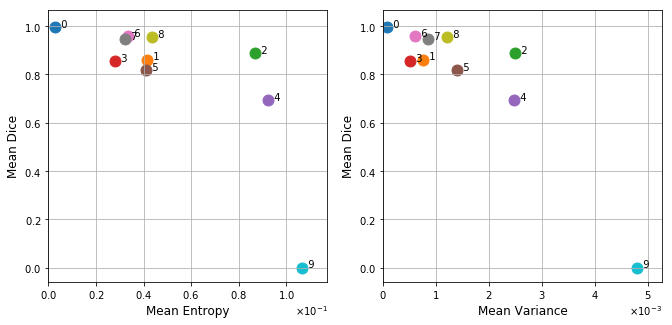

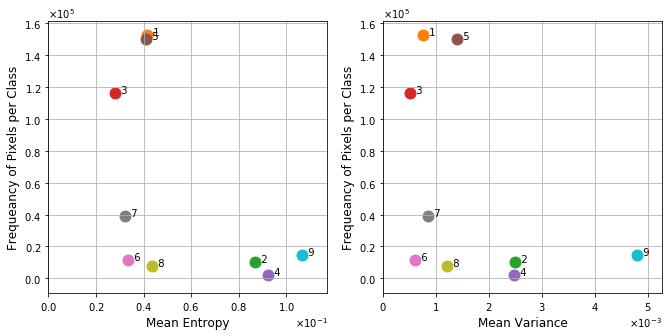

In [14]:
operation.analyse_ent_var_dice_and_draw_scatter_tumor(mode='Dropout')

[  48/  48] 100% |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| -
(c1-8)non_tumor_ent_per_px: 0.054744495250192204
(c1-8)non_tumor_var_per_px: 0.006287897080452624
(c1-8)tumor_ent_per_px: 0.16150279401270973
(c  9)tumor_var_per_px: 0.022207578766671576
(c1-9)all_tumor_ent_per_px: 0.05778688291031351
(c1-9)all_tumor_var_per_px: 0.006741574627553221
ents: [0.00425254 0.05253458 0.12712276 0.04337304 0.12477997 0.05606886
 0.08288796 0.05562906 0.08612832 0.16150279]
vars: [0.00030356 0.00529112 0.01307439 0.003787   0.01130319 0.00905947
 0.00638703 0.00496756 0.0061875  0.02220758]
dices: [0.994, 0.835, 0.899, 0.876, 0.676, 0.796, 0.897, 0.931, 0.932, 0.000] [0.855]


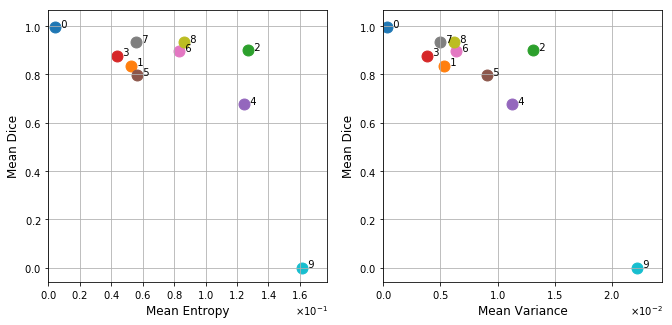

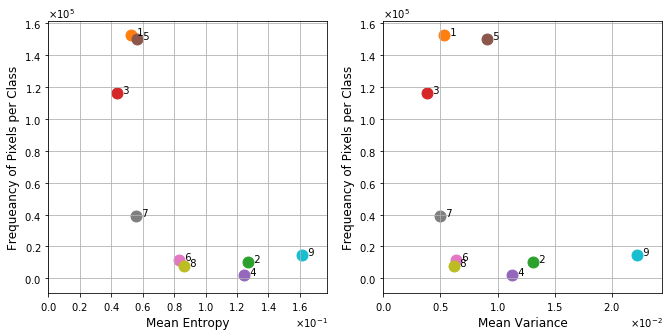

In [15]:
operation.analyse_ent_var_dice_and_draw_scatter_tumor(mode='Ensemble')

In [ ]:
operation.get_picture_many(mode='Ensemble')

In [ ]:
operation.get_picture_many(mode='Dropout')


[  48/  48] 100% |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| -
(c1-8)non_tumor_ent_per_px: 0.03733421640222467
(c1-8)non_tumor_var_per_px: 0.0009121926486021078
dices: [0.995, 0.871, 0.928, 0.859, 0.710, 0.822, 0.969, 0.955, 0.957] [0.884]


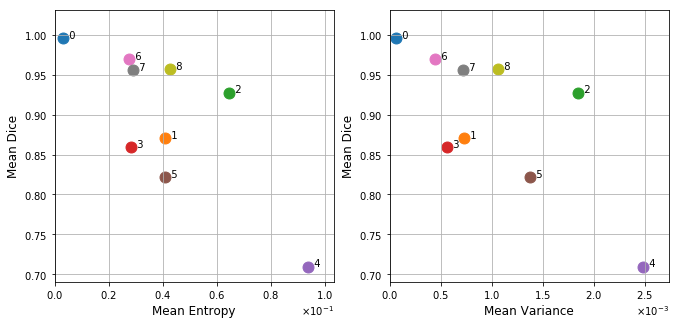

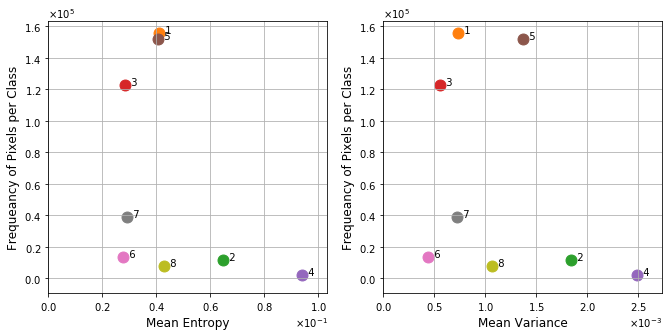

In [18]:
operation.analyse_ent_var_dice_and_draw_scatter(mode='Dropout')

[  48/  48] 100% |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| -
(c1-8)non_tumor_ent_per_px: 0.05203949165140854
(c1-8)non_tumor_var_per_px: 0.005887777192576202
dices: [0.995, 0.847, 0.922, 0.881, 0.692, 0.803, 0.898, 0.947, 0.933] [0.865]


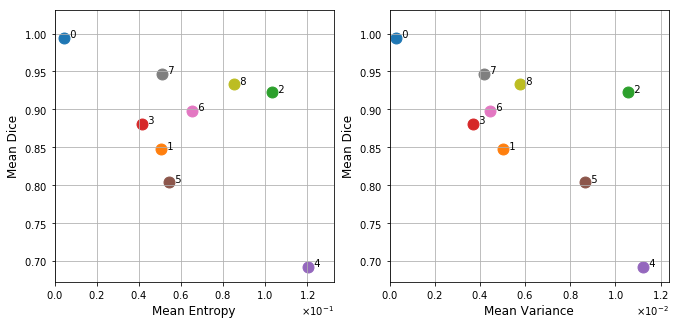

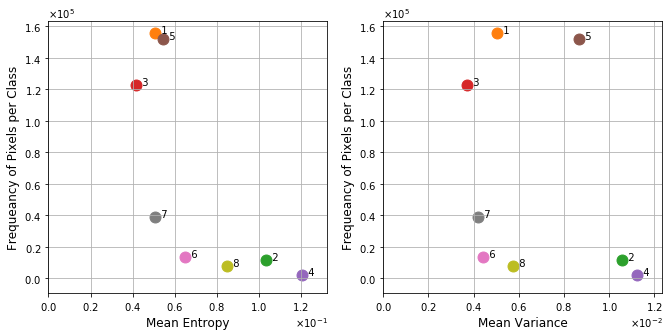

In [19]:
operation.analyse_ent_var_dice_and_draw_scatter(mode='Ensemble')